<a href="https://colab.research.google.com/github/kkrish39/Machine-learning-notebooks/blob/main/Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import plotly.graph_objs as go

from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
df_cgmSeries = pd.read_csv('/CGMSeriesLunchPat1.csv')
df_cgmDateNum = pd.read_csv('/CGMDatenumLunchPat1.csv')

In [ ]:
cgmSeriesArray = df_cgmSeries.to_numpy()
cgmDateNumArray = df_cgmDateNum.to_numpy()


In [ ]:
# reversing the arrays
cgmSeriesArray = cgmSeriesArray[...,::-1]
cgmDateNumArray = cgmDateNumArray[...,::-1]

In [ ]:
#removing the first column of the array since it holds some NaN values
cgmSeriesArray = cgmSeriesArray[:,1:]
cgmDateNumArray = cgmDateNumArray[:,1:]

In [ ]:
#removing null values
nanValueMapping = np.argwhere(np.isnan(cgmSeriesArray))
rowsToBeDeleted = np.unique(nanValueMapping[:,0])
cgmSeriesArray = np.delete(cgmSeriesArray,rowsToBeDeleted,0)
cgmDateNumArray = np.delete(cgmDateNumArray,rowsToBeDeleted,0)

In [ ]:
#Convert from epoch time to timeStamp
cgmDateNumArrayTransformed = []
for item in cgmDateNumArray:
    cgmDateNumArrayTransformed.append([dt.datetime.fromordinal(int(i)) + dt.timedelta(days=i%1) - dt.timedelta(days = 366) for i in item])


In [ ]:
#Matrix to store all the derived features
featureMatrix = pd.DataFrame() 

In [ ]:
#Expanding Window Statistics
tempFrame = pd.DataFrame(cgmSeriesArray)
expandingWindow = tempFrame.expanding(min_periods=2, axis=1).mean()
featureMatrix = pd.concat([expandingWindow.mean(),expandingWindow.min(), expandingWindow.max(),
(expandingWindow.max(axis=1) - expandingWindow.min(axis=1))/2], axis=1)
featureMatrix.columns = ['exp_row_mean', 'exp_row_min', 'exp_row_max', 'exp_min_max_average'] 


In [ ]:
trace1 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['exp_row_mean'],
        name='exp_row_mean')
trace2 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['exp_row_min'],
        name='exp_row_min')
trace3 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['exp_row_max'],
        name='exp_row_max')
trace4 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['exp_min_max_average'],
        name='exp_min_max_average')

In [ ]:

data = [trace1, trace2, trace3, trace4]
layout=go.Layout(
        yaxis = go.layout.YAxis(title='Glucose Level in the blood'),
        xaxis = go.layout.XAxis(title='Samples'),
        title = 'Subject 3')

fig = go.Figure(data=data, layout=layout)

In [ ]:
fig.show()

In [ ]:
#Skewness and Standard-Deviation
skewAndStdFrame = pd.DataFrame()

tempFrame = pd.DataFrame(cgmSeriesArray)
skewAndStdFrame = pd.concat([tempFrame.skew(skipna=True), tempFrame.std(skipna=True)], axis=1)
skewAndStdFrame.columns = ['std','skewness']
featureMatrix = pd.concat([featureMatrix, skewAndStdFrame], axis=1)

trace3 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['std'],
        name='std')
trace4 = go.Scatter(
        x=[' %s' %i for i in range(0,28)], 
        y=featureMatrix['skewness'],
        name='skewness')

In [ ]:
data = [trace3, trace4]
layout=go.Layout(
        yaxis = go.layout.YAxis(title='Glucose Level in the blood'),
        xaxis = go.layout.XAxis(title='Samples'),
        title = 'Subject 5')
fig = go.Figure(data=data, layout=layout)

In [ ]:
fig.show()

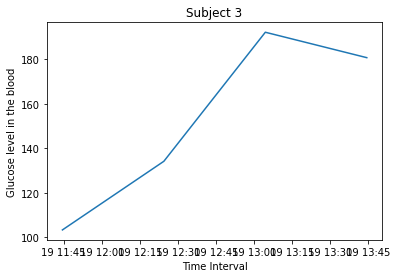

In [ ]:
#Finding moving average
cgmMovingAverage = pd.DataFrame(cgmSeriesArray)
window = 7 #for Every 35 minutes
movingAverage = pd.DataFrame()
rowVal, colVal = cgmMovingAverage.shape

for i in range(0,colVal-window,window):
    featureMatrix['mean_'+str((i/window)*35+35)+'min'] = cgmMovingAverage.iloc[:,i:i+window].mean(axis = 1)


for i in range (10, 20):
    plt.close('all')
    plt.title('Subject 3')
    plt.plot(cgmDateNumArrayTransformed[i][0:30:8], featureMatrix.iloc[i,6:10])
    plt.xlabel("Time Interval")
    plt.ylabel("Glucose level in the blood")

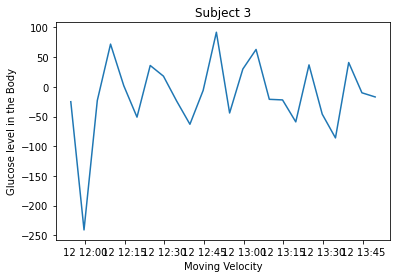

In [ ]:
#Finding Windowed velocity
window  = 6 #Taking the velocity for every half hour window
cgmWindowVelocity = pd.DataFrame()

row, col = cgmSeriesArray.shape
for i in range(0,col-window):
    cgmWindowVelocity['moving_velocity_'+str(i)] = (cgmSeriesArray[:][i+window]-cgmSeriesArray[:][i])


for i in range(3,13):
    plt.close('all')
    plt.plot(cgmDateNumArrayTransformed[i][0:col-window],cgmWindowVelocity.iloc[i])
    plt.title('Subject 3')
    plt.xlabel('Moving Velocity')
    plt.ylabel('Glucose level in the Body')

Text(0.5, 0, 'samples')

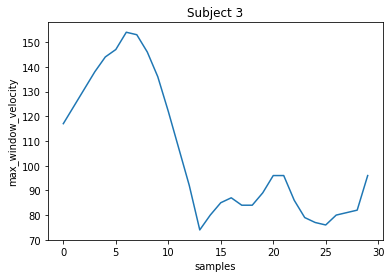

In [ ]:
featureMatrix['max_window_velocity'] = cgmWindowVelocity.max(axis = 1, skipna=True) #Finding the maxWindow Velocity for a given row

plt.plot(featureMatrix['max_window_velocity'])
plt.title('Subject 3')
plt.ylabel('max_window_velocity')
plt.xlabel('samples')

In [ ]:
#Caluclating PCA
featureMatrix = featureMatrix.dropna()


row, col = featureMatrix.shape
X = featureMatrix.iloc[:,:].values
Y = featureMatrix.iloc[:,:].values

featureMatrix_std = StandardScaler().fit_transform(X)

In [ ]:
cov_mat = np.cov(featureMatrix_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
sorted(eig_pairs,key=lambda x: x[0])

[(0.0024257691106408866,
  array([ 0.44072195,  0.13957593,  0.46295437, -0.01609357,  0.1785598 ,
         -0.71305584, -0.06345676,  0.06195373,  0.01224013, -0.01448835,
          0.15211834])),
 (0.004163071092694972,
  array([ 0.72265393, -0.58225679, -0.22599663, -0.00466275,  0.13072586,
          0.23694623, -0.0377101 ,  0.00197581,  0.08617638, -0.04809567,
          0.0570423 ])),
 (0.01814886821264198,
  array([ 0.05100419,  0.06733152, -0.07414446,  0.04384602,  0.07715075,
          0.09249172, -0.39611749,  0.6350599 , -0.5597038 ,  0.3118445 ,
          0.01458503])),
 (0.046465656520625724,
  array([ 0.1777153 ,  0.53269679, -0.45914992,  0.01506792,  0.60146518,
          0.00581221,  0.0049149 , -0.0404249 ,  0.08971178, -0.14294755,
         -0.28578144])),
 (0.09185141432446041,
  array([ 0.0817463 , -0.03089272, -0.06336753, -0.26914784,  0.10397123,
         -0.073021  ,  0.53711037, -0.31334359, -0.42518643,  0.57243396,
         -0.06803822])),
 (0.160107989138

In [ ]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

In [ ]:
trace1 = go.Bar(
        x=['PCA %s' %i for i in range(0,5)],
        y=var_exp,
        showlegend=False)

trace2 = go.Scatter(
        x=['PCA %s' %i for i in range(0,5)], 
        y=cum_var_exp,
        name='cumulative explained variance')

data = [trace1, trace2]
layout=go.Layout(
        yaxis = go.layout.YAxis(title='Variance in percent'),
        title = 'Variance by different principal components')

fig = go.Figure(data=data, layout=layout)

In [ ]:
fig.show()

In [ ]:
# Alternate and simplified way calculate PCA. Both will result in same value
featureMatrix.to_csv('featureMatrix.csv',index=None, header=True)

In [ ]:
featureMatrix = StandardScaler().fit_transform(featureMatrix)
pca = PCA(n_components=5)
principalComponents = pca.fit(featureMatrix)
transformedPrincipalComponent = pca.fit_transform(featureMatrix)

In [ ]:
finalPrincipalComponents = pd.DataFrame(data=transformedPrincipalComponent, columns = ['PC1', 'PC2','PC3', 'PC4','PC5'])

finalPrincipalComponents.to_csv('pca.csv', index=None, header=True)

In [ ]:
trace2 = go.Scatter(
        x=['%s' %i for i in range(0,29)], 
        y=finalPrincipalComponents['PC1'],
        mode="markers")

layout=go.Layout(
        yaxis = go.layout.YAxis(title='Feature 1'),
        xaxis = go.layout.XAxis(title='Time Series'),
        title = 'Scatter Plot for Feature 1')

trace2 = [trace2]
fig = go.Figure(data=trace2, layout=layout)

In [ ]:
fig.show()

In [ ]:
trace2 = go.Scatter(
        x=['%s' %i for i in range(0,29)], 
        y=finalPrincipalComponents['PC2'],
        mode="markers")

layout=go.Layout(
        yaxis = go.layout.YAxis(title='Feature 2'),
        xaxis = go.layout.XAxis(title='Time Series'),
        title = 'Scatter Plot for Feature 2')

trace2 = [trace2]
fig = go.Figure(data=trace2, layout=layout)

In [ ]:
fig.show()

In [ ]:
trace2 = go.Scatter(
        x=['%s' %i for i in range(0,29)], 
        y=finalPrincipalComponents['PC3'],
        mode="markers")

layout=go.Layout(
        yaxis = go.layout.YAxis(title='Feature 3'),
        xaxis = go.layout.XAxis(title='Time Series'),
        title = 'Scatter Plot for Feature 3')

trace2 = [trace2]
fig = go.Figure(data=trace2, layout=layout)

In [ ]:
fig.show()

In [ ]:

trace2 = go.Scatter(
        x=['%s' %i for i in range(0,29)], 
        y=finalPrincipalComponents['PC4'],
        mode="markers")

layout=go.Layout(
        yaxis = go.layout.YAxis(title='Feature 4'),
        xaxis = go.layout.XAxis(title='Time Series'),
        title = 'Scatter Plot for Feature 4')

trace2 = [trace2]
fig = go.Figure(data=trace2, layout=layout)

In [ ]:
fig.show()

In [ ]:
trace2 = go.Scatter(
        x=['%s' %i for i in range(0,29)], 
        y=finalPrincipalComponents['PC5'],
        mode="markers")

layout=go.Layout(
        yaxis = go.layout.YAxis(title='Feature 5'),
        xaxis = go.layout.XAxis(title='Time Series'),
        title = 'Scatter Plot for Feature 5')

trace2 = [trace2]
fig = go.Figure(data=trace2, layout=layout)

In [ ]:
fig.show()